# Plot external KE sources & sinks (Figure 4)

In [3]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.pylab as pylab

In [4]:
import numpy as np
import xarray as xr
from xgcm import Grid
from dask.diagnostics import ProgressBar

In [5]:
# Filter Specs
filter_fac = 32

run = 'nw2_0.03125deg_N15_baseline_hmix20'
basepath = '/glade/p/univ/unyu0004/gmarques/NeverWorld2/baselines/'
workpath = '/glade/work/noraloose/' 

In [6]:
st = xr.open_dataset('%s/%s/static.nc' % (basepath,run), decode_times=False)

# for 500 day averages
ds_lorenz = xr.open_dataset('%s/%s/lorenz_cycle_fac%i_500days.nc' % (workpath, run, filter_fac), decode_times=False)
ds_bleck = xr.open_dataset('%s/%s/bleck_cycle_fac%i_500days.nc' % (workpath, run, filter_fac), decode_times=False)

## Plotting

In [7]:
import copy
cmap = copy.copy(mpl.cm.get_cmap("RdBu_r"))
cmap.set_bad(color='gray')
extent = [0, 60, -70, 70]

In [8]:
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'font.size': 14}
pylab.rcParams.update(params)

### Total (MKE + EKE) contributions
Note that for the computation in the following cell it does not matter whether `ds_lorenz` or `ds_bleck` is used because the total (MKE + EKE) contributions are the same in the two frameworks.

In [12]:
ds_lorenz['total_wind_stress'] = ds_lorenz['MKE_wind_stress'] + ds_lorenz['EKE_wind_stress']
ds_lorenz['total_bottom_drag'] = ds_lorenz['MKE_bottom_drag'] + ds_lorenz['EKE_bottom_drag']
ds_lorenz['total_horizontal_viscosity'] = ds_lorenz['MKE_horizontal_viscosity'] + ds_lorenz['EKE_horizontal_viscosity']
ds_lorenz['total_vertical_viscosity'] = ds_lorenz['MKE_vertical_viscosity'] + ds_lorenz['EKE_vertical_viscosity']

### Wind work and bottom drag (top left of figure)

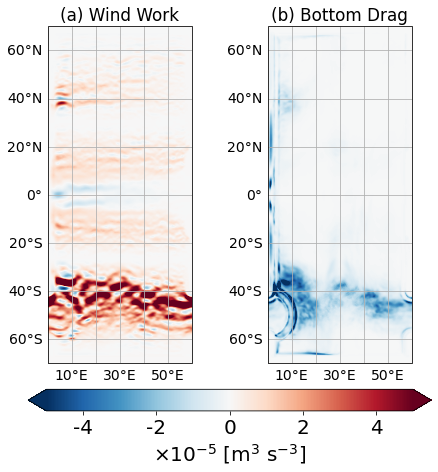

In [14]:
vmax= 0.00005
fldlist = ['total_wind_stress','total_bottom_drag']
labellist = ['(a) Wind Work', '(b) Bottom Drag']
  

fig,axs = plt.subplots(1,2,figsize=(7,6),subplot_kw={'projection':ccrs.PlateCarree()})
for fld, lb, ax in zip(fldlist, labellist, axs.flatten()):
    p = ds_lorenz[fld].plot(
        ax=ax, 
        vmax=vmax, vmin=-vmax, cmap='RdBu_r',
        add_colorbar=False,
        transform=ccrs.PlateCarree()
    ) 
    ax.set(title = lb)
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    
# colorbar
fig.subplots_adjust(left=0.1, bottom=0.1)
cax = fig.add_axes([0.1, -0.01, 0.8, 0.05])
cb = fig.colorbar(p, cax=cax, extend='both', orientation='horizontal',
                  ticks=1e-5*np.arange(-4,5,2))
cb.ax.tick_params(labelsize=20)
cb.set_label(label=r'$\times 10^{-5}$ [m$^3$ s$^{-3}$]', size=20)
cb.ax.set_xticklabels(['-4','-2','0','2','4'])

figname = 'figures/energy_sources_sinks_1_fac%i.png' %filter_fac

plt.savefig(figname,dpi=200,bbox_inches='tight',pad_inches=0)

### Vertical and horizontal friction (top right of figure)

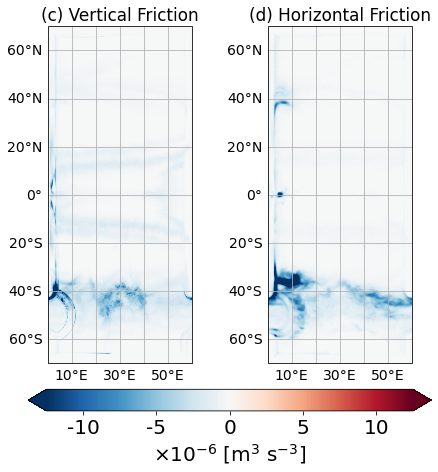

In [15]:
vmax= 0.0000125
fldlist = ['total_vertical_viscosity', 'total_horizontal_viscosity']
labellist = ['(c) Vertical Friction', '(d) Horizontal Friction']
 
    
fig,axs = plt.subplots(1,2,figsize=(7,6),subplot_kw={'projection':ccrs.PlateCarree()})
for fld, lb, ax in zip(fldlist, labellist, axs.flatten()):
    p = ds_lorenz[fld].plot(
        ax=ax, 
        vmax=vmax, vmin=-vmax, cmap='RdBu_r',
        add_colorbar=False,
        transform=ccrs.PlateCarree()
    ) 
    ax.set(title = lb)
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False
    
# colorbar
fig.subplots_adjust(left=0.1, bottom=0.1)
cax = fig.add_axes([0.1, -0.01, 0.8, 0.05])
cb = fig.colorbar(p, cax=cax, extend='both', orientation='horizontal',
                  ticks=1e-6*np.arange(-10,11,5))
cb.ax.tick_params(labelsize=20)
cb.set_label(label=r'$\times 10^{-6}$ [m$^3$ s$^{-3}$]', size=20)
cb.ax.set_xticklabels(['-10','-5','0','5','10'])

figname = 'figures/energy_sources_sinks_2_fac%i.png' %filter_fac

plt.savefig(figname, dpi=200, bbox_inches='tight', pad_inches=0)

### Domain integrals

In [16]:
dst_integrals = xr.Dataset()

In [20]:
fldlist_non_TWA = [
    'MKE_wind_stress', 'MKE_vertical_viscosity', 'MKE_bottom_drag', 'MKE_horizontal_viscosity',
    'EKE_wind_stress', 'EKE_vertical_viscosity', 'EKE_bottom_drag', 'EKE_horizontal_viscosity'
]
fldlist_TWA = [
    'MKE_wind_stress_TWA', 'MKE_vertical_viscosity_TWA', 'MKE_bottom_drag_TWA', 'MKE_horizontal_viscosity_TWA',
    'EKE_wind_stress_TWA', 'EKE_vertical_viscosity_TWA', 'EKE_bottom_drag_TWA', 'EKE_horizontal_viscosity_TWA'
]
                   
for fld in fldlist_non_TWA:
    dst_integrals[fld] = (ds_lorenz[fld] * st.area_t).sum(dim=['xh', 'yh'])
for fld in fldlist_TWA:
    dst_integrals[fld] = (ds_bleck[fld] * st.area_t).sum(dim=['xh', 'yh'])

In [22]:
dst_integrals['total_wind_stress'] = dst_integrals['MKE_wind_stress'] + dst_integrals['EKE_wind_stress']
dst_integrals['total_vertical_viscosity'] = dst_integrals['MKE_vertical_viscosity'] + dst_integrals['EKE_vertical_viscosity']
dst_integrals['total_bottom_drag'] = dst_integrals['MKE_bottom_drag'] + dst_integrals['EKE_bottom_drag']
dst_integrals['total_horizontal_viscosity'] = dst_integrals['MKE_horizontal_viscosity'] + dst_integrals['EKE_horizontal_viscosity']

#dst_integrals['total_wind_stress_TWA'] = dst_integrals['MKE_wind_stress_TWA'] + dst_integrals['EKE_wind_stress_TWA']
#dst_integrals['total_vertical_viscosity_TWA'] = dst_integrals['MKE_vertical_viscosity_TWA'] + dst_integrals['EKE_vertical_viscosity_TWA']
#dst_integrals['total_bottom_drag_TWA'] = dst_integrals['MKE_bottom_drag_TWA'] + dst_integrals['EKE_bottom_drag_TWA']
#dst_integrals['total_horizontal_viscosity_TWA'] = dst_integrals['MKE_horizontal_viscosity_TWA'] + dst_integrals['EKE_horizontal_viscosity_TWA']

### Bar plot with integrals (bottom half of figure)

In [23]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'font.size': 14}
pylab.rcParams.update(params)

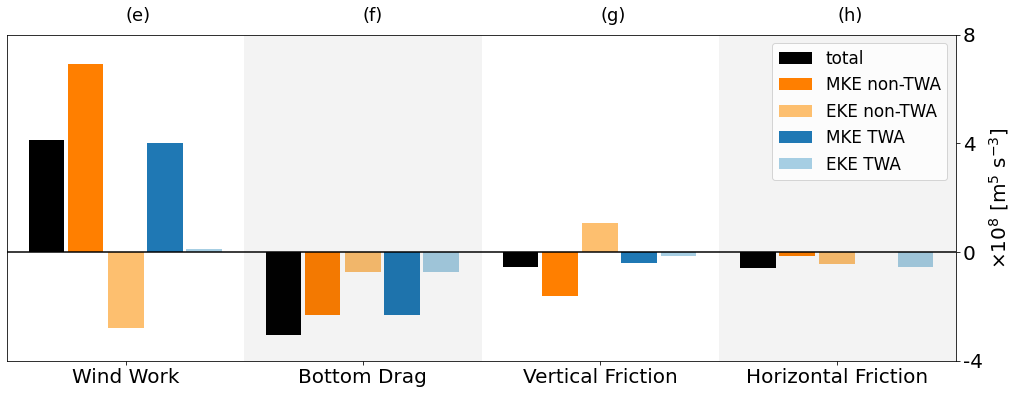

In [26]:
fig,ax = plt.subplots(1,1,figsize=(17,6))

X = np.array([0, 2, 4, 6])

ax.bar(X + 0.33, [
    dst_integrals['total_wind_stress'],
    dst_integrals['total_bottom_drag'], 
    dst_integrals['total_vertical_viscosity'], 
    dst_integrals['total_horizontal_viscosity']
], color = 'k', label='total', width = 0.3)

ax.bar(X + 0.66, [
    dst_integrals['MKE_wind_stress'],
    dst_integrals['MKE_bottom_drag'],     
    dst_integrals['MKE_vertical_viscosity'], 
    dst_integrals['MKE_horizontal_viscosity']
], color='#ff7f00', label='MKE non-TWA', width  = 0.3)

ax.bar(X + 1, [
    dst_integrals['EKE_wind_stress'],
    dst_integrals['EKE_bottom_drag'], 
    dst_integrals['EKE_vertical_viscosity'], 
    dst_integrals['EKE_horizontal_viscosity']
], color='#fdbf6f', label='EKE non-TWA', width  = 0.3)

ax.bar(X + 1.33, [
    dst_integrals['MKE_wind_stress_TWA'],
    dst_integrals['MKE_bottom_drag_TWA'], 
    dst_integrals['MKE_vertical_viscosity_TWA'], 
    dst_integrals['MKE_horizontal_viscosity_TWA'] 
], color='#1f78b4', label='MKE TWA', width  = 0.3)
#hatch='\\', 

ax.bar(X + 1.66, [
    dst_integrals['EKE_wind_stress_TWA'],
    dst_integrals['EKE_bottom_drag_TWA'], 
    dst_integrals['EKE_vertical_viscosity_TWA'], 
    dst_integrals['EKE_horizontal_viscosity_TWA']
], color='#a6cee3', label='EKE TWA', width  = 0.3)


ax.set_xticks([1, 3, 5, 7])
ax.set_xticklabels(['Wind Work', 'Bottom Drag', 'Vertical Friction', 'Horizontal Friction'])
ax.set_xlabel('')

ax.axvspan(2, 4, facecolor='0.1', alpha=0.05)
ax.axvspan(6, 8, facecolor='0.1', alpha=0.05)
ax.hlines(0, 0, 8, color='k')
ax.set_xlim([0,8])
ax.legend(loc='upper right')
ax.set_yticks(ticks=np.arange(-4, 12, 4)*1e8)
ax.set(yticklabels=['-4', '0', '4', '8'])
ax.set(ylabel=r'$\times 10^8$ [m$^5$ s$^{-3}$]')
ax.yaxis.label.set_size(20)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.tick_params(labelsize=20)

ax.text(1, 8.5e8, '(e)', fontsize=18)
ax.text(3, 8.5e8, '(f)', fontsize=18)
ax.text(5, 8.5e8, '(g)', fontsize=18)
ax.text(7, 8.5e8, '(h)', fontsize=18)

plt.subplots_adjust(wspace=1)  
figname = 'figures/energy_sources_sinks_3_fac%i.png' %filter_fac
plt.savefig(figname, dpi=200, bbox_inches='tight', pad_inches=0)